In [397]:
! nvidia-smi

Sat Apr  9 10:09:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   4330MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [398]:
#content to google drive
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [399]:
!pip install tensorflow==2.2.0
!pip install keras==2.4.2
!pip install segmentation_models

In [400]:
# Enter modules
import zipfile  # For faster extraction
import keras
import tensorflow as tf
import os
from numpy import expand_dims
import cv2 # for read image
import numpy as np # For data manipulation
import matplotlib.pyplot as plt # for draw
from google.colab.patches import cv2_imshow #coordinate cv2 with colab
import nibabel as nib  #To read nii format
import re  # For parsing the filenames (to know their modality)
import glob # For populating the list of files
import imgaug.augmenters as iaa #for data agumention
from sklearn.model_selection import KFold, StratifiedKFold #Data setup and data segmentation
import imgaug as ia
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import time
import datetime
import os
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
import segmentation_models as sm

In [401]:
import os
import nibabel as nib
T2W=os.listdir('/content/drive/MyDrive/prostate_crop/T2W_crop')
print(len(T2W))

T2W_imag=[]
X=[]
for i in T2W:
  T2W_imag.append('/content/drive/MyDrive/prostate_crop/T2W_crop/' + i )
for j in T2W_imag:
  img= nib.load(j)
  t2w_img = img.get_fdata(caching='unchanged') 
  X.append(t2w_img)  

42


In [402]:
label=os.listdir('/content/drive/MyDrive/prostate_crop/Label_crop')
print(len(label))
label_imag=[]
Y=[]
for i in label:
  label_imag.append('/content/drive/MyDrive/prostate_crop/Label_crop/' + i )
for j in label_imag:
  img= nib.load(j)
  lbl_img = img.get_fdata(caching='unchanged') 
  Y.append(lbl_img)  

42


In [403]:
print(len(X),len(Y))

42 42


In [404]:
X=np.array(X)
Y=np.array(Y)

In [405]:
np.unique(Y[0])

array([0., 1., 2., 3., 4.])

In [406]:
from sklearn.model_selection import KFold
i=0 
n_split=10
 
for train_index,test_index in KFold(n_split).split(X):
  if i==9:
    X_train,X_val=X[train_index],X[test_index]
    y_train,y_val=Y[train_index],Y[test_index]
  i=i+1  


print(len(X_train),len(y_train))
print(len(X_val),len(y_val))

38 38
4 4


In [407]:
print(X_train.shape , y_train.shape ,X_val.shape, y_val.shape )

(38, 160, 160, 19) (38, 160, 160, 19) (4, 160, 160, 19) (4, 160, 160, 19)


In [408]:
X_T=[]
for i in range (0,len(X_train)):
  for j in range(0,19):
    img=X_train[i][:,:,j]
    X_T.append(img)

Y_T=[]
for i in range (0,len(y_train)):
  for j in range(0,19):
    img=y_train[i][:,:,j]
    Y_T.append(img)    

X_V=[]
for i in range (0,len(X_val)):
  for j in range(0,19):
    img=X_val[i][:,:,j]
    X_V.append(img) 
Y_V=[]
for i in range (0,len(y_val)):
  for j in range(0,19):
    img=y_val[i][:,:,j]
    Y_V.append(img)              

In [409]:
np.unique(Y_V[0])

array([0., 3.])

In [410]:
print(len(X_T) , len(Y_T), len(X_V),len(Y_V))

722 722 76 76


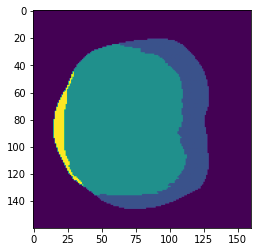

In [411]:
plt.imshow(Y_T[7])

In [412]:
Y_T_c=to_categorical(Y_T,5)
Y_V_c=to_categorical(Y_V,5)

In [413]:
np.unique(Y_T_c[0])

array([0., 1.], dtype=float32)

In [414]:
X_T=np.array(X_T)
Y_T_c=np.array(Y_T_c)
X_V=np.array(X_V)
Y_V_c=np.array(Y_V_c)

In [415]:
X_T=np.expand_dims(X_T, axis=-1)
X_V=np.expand_dims(X_V, axis=-1)

In [416]:
print(X_T.shape , Y_T_c.shape ,X_V.shape, Y_V_c.shape )

(722, 160, 160, 1) (722, 160, 160, 5) (76, 160, 160, 1) (76, 160, 160, 5)


In [417]:
import random
def Data_generator_train(X,y, batch_size=8):   
    while True:               
          for start in range(0, X.shape[0], batch_size):
              x_batch = []
              y_batch = []
              end = min(start + batch_size, X.shape[0])
              ids_batch = X[start:end]
              for idd in range(start,end):           
                   a=random.randint(0,2)
                   if a==0:
                      image =np.fliplr(X[idd]) 
                      label =np.fliplr(y[idd])
                   if a==1:
                     image =np.flipud(X[idd]) 
                     label =np.flipud(y[idd])
                   elif a==2:
                     image =(X[idd]) 
                     label =(y[idd])                
                   x_batch.append(image)
                   y_batch.append(label)               
              x_batch= np.array(x_batch)
              y_batch= np.array(y_batch)                                           
              yield x_batch, y_batch


In [418]:
m,b=next(iter(Data_generator_train(X_T,Y_T_c)))

print(m.shape)
print(b.shape)

(8, 160, 160, 1)
(8, 160, 160, 5)


In [419]:
import random
def Data_generator_test(X,y, batch_size=1):   
    while True:               
          for start in range(0, X.shape[0], batch_size):
              x_batch = []
              y_batch = []
              end = min(start + batch_size, X.shape[0])
              ids_batch = X[start:end]
              for idd in range(start,end):           
                image =(X[idd]) 
                label =(y[idd])                
                x_batch.append(image)
                y_batch.append(label)               
              x_batch= np.array(x_batch)
              y_batch= np.array(y_batch)                                           
              yield x_batch, y_batch


In [420]:
m,b=next(iter(Data_generator_test(X_V,Y_V_c)))

print(m.shape)
print(b.shape)

(1, 160, 160, 1)
(1, 160, 160, 5)


In [421]:
model= sm.Unet('resnet34', classes=5, activation='softmax', encoder_weights=None, input_shape=(160, 160, 1))

In [422]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 160, 160, 1)  3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_306 (ZeroPadding (None, 166, 166, 1)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 80, 80, 64)   3136        zero_padding2d_306[0][0]         
___________________________________________________________________________________________

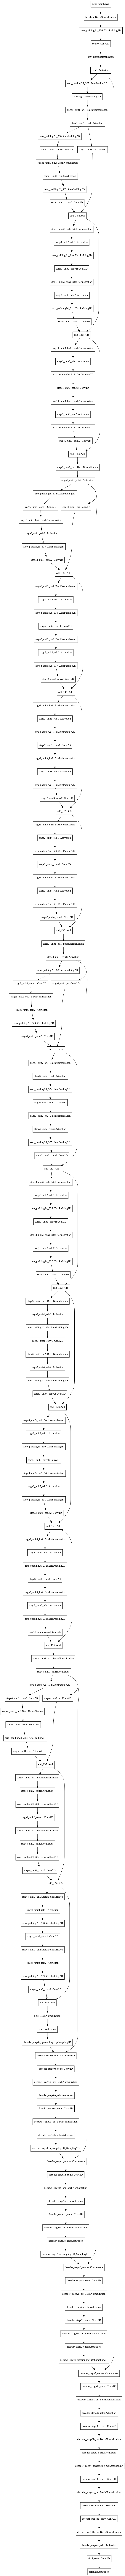

In [423]:
tf.keras.utils.plot_model(model)

In [424]:
optim = tf.keras.optimizers.Adam(lr =0.0008)
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']

In [425]:
model.compile(optim, total_loss, metrics)

In [426]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger

model_checkpoint = ModelCheckpoint('/content/drive/My Drive/unet_resnet34_T2W/'+'unet_resnet34_fold10.h5', save_best_only=True,save_weights_only=True, verbose=2, monitor='val_f1-score',mode='max')
csv_logger = CSVLogger('/content/drive/My Drive/unet_resnet34_T2W/'+'unet_resnet34_fold10.csv', append=True)

In [427]:
def step_decay(epoch):
     
     initAlpha = 0.0008
     factor = .9
     dropEvery = 30
     alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
     return float(alpha)

In [428]:
batch_size =8
TrainSteps = len(X_T)  / batch_size
ValSteps   = len(X_V)

In [429]:
model.load_weights('/content/drive/My Drive/unet_resnet34_T2W/unet_resnet34_fold10.h5')

In [430]:
scores=model.evaluate(X_V,Y_V_c , batch_size=1)
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric, value))

76/76 [==============================] - 2s 25ms/step - loss: 1.0215 - iou_score: 0.4886 - f1-score: 0.5102 - accuracy: 0.7062
Loss: 1.0215
mean <segmentation_models.metrics.IOUScore object at 0x7f8fab8e52d0>: 0.4886
mean <segmentation_models.metrics.FScore object at 0x7f8fb48b3390>: 0.51019
mean accuracy: 0.70617


In [431]:
p=model.predict(X_V)
y=Y_V_c

In [432]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,0], y[i,:,:,0])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


76
0.11193600870331195


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


In [433]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,1], y[i,:,:,1])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


76
0.04594338036221046


In [434]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,2], y[i,:,:,2])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


76
0.029266176909820685


In [435]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,3], y[i,:,:,3])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


76
0.028171424929108554


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


In [436]:
from scipy.spatial.distance import directed_hausdorff


def Average(lst):
    return sum(lst) / len(lst)



HD=[]
for i in range(0,76):
  hd=directed_hausdorff(p[i,:,:,4], y[i,:,:,4])
  HD.append(hd[0])

print(len(HD))
print(Average(HD))


/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


76
0.01896201528997288


In [437]:
pred=np.argmax(p, axis=-1)
ytrue=np.argmax(y, axis=-1)

In [438]:
Pred=pred.flatten()
Ytrue=ytrue.flatten()

In [439]:
Ytrue.shape

(1945600,)

In [440]:
from sklearn.metrics import classification_report
print(classification_report(Pred, Ytrue, digits=4))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     1.0000    0.7062    0.8278   1945600
           1     0.0000    0.0000    0.0000         0
           2     0.0000    0.0000    0.0000         0
           3     0.0000    0.0000    0.0000         0
           4     0.0000    0.0000    0.0000         0

    accuracy                         0.7062   1945600
   macro avg     0.2000    0.1412    0.1656   1945600
weighted avg     1.0000    0.7062    0.8278   1945600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
